# Introduction

audGrav is a compositional tool, implemented in python, that allows a user to algorithmically edit and rearrange audio clips, both in time and space, using the equation of gravity.

After the audio file is read, the program, with user-defined attack and release thresholds, will edit out each audio event and treat it as an independent body. An audio event, in this case, is defined as a section of audio that is preceded and followed by the noise floor of the original sound file. The equation of gravity is used to create a relationship between each audio event based on its mass and distance from other events. For our purposes, mass is equated as the RMS value of each event and the distance is the time, in seconds squared, in between each events peak index. When actually calculating gravity, we would multiply the equation by the gravitational constant, 9.81 meters per seconds squared, but since audio has no gravitational constant this parameter is exposed to the user to change and affect how dramatic the shifting is. The end result is a new audio file with events that have shifted in time and space (stereo panning) based on mass and distances.

## Installation:  

`pip install git+https://github.com/patrickTumulty/pyAudGrav`

# Getting Started 

After ensuring that you have the neccessary depencies installed to your current working environment you can
import the `SignalLibrary` module

Once you have copied the audio file that you wish to import into your working directory you can proceed to 
create a WavFile object.


In [1]:
%matplotlib inline 

In [2]:
import pyAudGrav
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

audio_file = "example2_tones.wav"

io = pyAudGrav.AudioIO(audio_file) 
sig = pyAudGrav.AudioAnalysis(io.data, io.sample_rate)

Loaded example2_tones.wav | Sample Rate : 44100 | Channels : mono


## Get Signal Envelope 

Before you can extract the various audio events from the imported sound file you will need to first analyze
the signals envelope. The AudioAnalysis class has two methods to do this. The methods are `get_env_peak()` and `get_env_rms()`. I recommend mostly using `get_env_peak()` for it returns a very smooth envelope
without attenuating the signal. Adjusting the parameters of `get_env_peak()` will adjust the envelopes resolution. The default values should be fine for more usecases. 


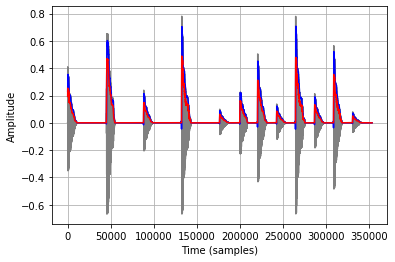

In [3]:
b = 35
lpf = 100
fOrder = 4

envPEAK = sig.get_env_peak(sig.data, b, lpf, fOrder)

windowSize = 200

envRMS = sig.get_env_rms(sig.data, windowSize)

plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.plot(sig.data, 'grey')
plt.plot(envPEAK, 'blue')
plt.plot(envRMS, 'red')
plt.grid()
plt.show()

## Populate the `audio_events` List

*NOTE: This step can be skipped in the case that you are using the `calc_shift()` function.*

The next step will be to populate the audio events list, accessible via the AudioAnalysis object. After the audio has been analyzed, the indivdual audio events will be represented as objects of the `AudioEvent()` class.
Using a generated envelope (see previous section) we can excute the following code. 

In [4]:
atk = 0.01
rel = 0.009

sig.get_audio_events(sig.data, envPEAK, atk, rel)

I recommend fine tuning the atkThresh and relThresh to achieve the best results. 
If you are unsure of what to set these values to I recommend using a graph, like the one displayed above, to assess the threshold of a given audio signal. 
My method for deciding attack and release threshold values is to plot the original `sig.data` overlayed with the `get_env_peak()` envelope and assess what attak and release values I would need to capture the smallest audio event in my signal. 

## Calculating the Audio Shift (AUDIO GRAVITY)

### pyAudGrav Math

The main feature of this library is rearranging audio events in time, along its timeline, and in space, with stereo pannning. 
To determine the behavior of the audio events movement along a timeline, that isn't random, we use the equation of 
gravity as a model.

## $g = \frac{G \left( m1 \cdot m2 \right) }{r^2}$

Obviously audio events don't have mass or distance that we can calculate, so we needed to take some artistic
liberties with this equation. For our purposes mass = the root means square (RMS) of the given signal. The distance 
$r$ is time, in seconds, derived from the number of samples in between each audio events envelope peak index. 
We use this equation to return an integer of + or - samples shifted.  

To calculate gravity for all elements in a list we implement this equation in the form of matricies. 

## $ g = G(\frac{M}{R^2}s \cdot mR)$

In this case $M$ represents a matrix of RMS (mass) values which is then divided by the squared value of $R$, a matrix of time distances (in seconds). $S$ represents the audio sampling rate which multiplies the quotient into a number of samples. At this point we have a matrix of values that is symmetrical above the leading diagnol. This is not what we want. We then multiply this matrix by $mR$ which is a matrix of ratio values, in which any two audio events will have a ratio that will sum to 1, derived from their RMS (mass). Below is an example of what this ratio matrix might look like. 

\begin{equation}
  \begin{bmatrix}
    0 & 0.75 & 0.4 \\
    0.25 & 0 & 0.5 \\
    0.6 & 0.5 & 0
  \end{bmatrix}
  \label{eq:aeqn}
\end{equation}

In this equation $G$ is an integer or a float. It is used to scale the shifted values, thus making the shifting more or less dramatic. There is still one more step that needs to be addressed. We squared all of our time distances thus making all values in the matrix positive. Negative values move the audio event left in the time domain, and vice versa, positive values move it right. The solution to this is to simply make all values above the leading diagnol negative. The last step is to sum each column into a 1D array with each element indicating a total number of samples shifted for each audio event. 

### Code Examples

The method for calculating the shift amount for each AudioEvent is called `calc_shift()`. Conveniently 
`calc_shift()` will populate the `audio_events` list for you if you haven't already done so. Meaning you are not 
required to run `get_audio_events()` first.

In [5]:
atk_thresh  = 0.02      # atk and rel threshold, see SIGNAL ENVELOPE PLOT above
rel_thresh  = 0.001
gConst      = 5         # how much will the various audio events displace eachother in time 
panRatio    = 20        # compression ratio for panning values
panThresh   = 20        # compresstion threshold for pan values (between 0 - 100)
mag_scale   = 'RMS'     # RMS is recommended, but LUFS is an option

sig.calc_shift(sig.data, envPEAK, atk_thresh, rel_thresh, gConst, panRatio, panThresh, mag_scale)

## Reconstruction

### Mono 

After above steps have been completed you can begin to reconstruct your signal. The process is similar for both
Mono and Stereo. The first step is creating a new array that your audio will be added to. After that you can pass in your newly created array and your audio event list into the into the `reconstruct_mono()` method. 

In [6]:
array_length = len(sig.data)

R_mono = pyAudGrav.AudioReconstruct(array_length, sig.audio_events)
r_mono = R_mono.reconstruct_mono()

Reconstructing MONO signal...


### Stereo

Reconstructing a stereo signal is nearly identical. 

In [7]:
R_stereo = pyAudGrav.AudioReconstruct(array_length, sig.audio_events)
r_stereo = R_stereo.reconstruct_stereo()

Reconstructing STEREO signal...


## Visualizion: Time Shift

In this example you will be able to see how the audio events move in time after they have been reconstructed. Note that adjusting the `G` parameter will affect how much or how little the events will be shifted in time. The blue dots on this graph illustrate the pan offset of each audio event. Postitive values are panned to the left and negative values are panned to the right.  

Reconstructing STEREO signal...


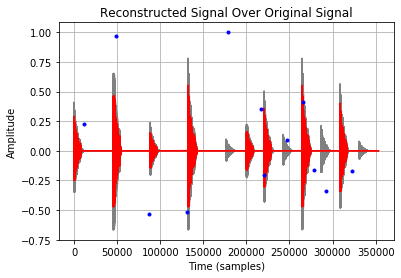

In [12]:
atk_thresh  = 0.02      # atk and rel threshold, see SIGNAL ENVELOPE PLOT above
rel_thresh  = 0.001
gConst      = 10         # how much will the various audio events displace eachother in time 
panRatio    = 20        # compression ratio for panning values
panThresh   = 20        # compresstion threshold for pan values (between 0 - 100)
mag_scale   = 'RMS'     # RMS is recommended, but LUFS is an option

sig.calc_shift(sig.data, envPEAK, atk_thresh, rel_thresh, gConst, panRatio, panThresh, mag_scale)

R_stereo = pyAudGrav.AudioReconstruct(len(sig.data), sig.sample_rate)
r_stereo = R_mono.reconstruct_stereo()

plt.title("Reconstructed Signal Over Original Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.plot([i + R_stereo.correction for i in range(len(sig.data))],
         [item for item in sig.data],'grey')
plt.plot(r_stereo, 'r')
plt.plot([obj.peakIdx + obj.offset +  R_stereo.correction for obj in sig.audio_events], 
         [obj.panOffset * 0.01 for obj in sig.audio_events], '.b')
plt.grid()
plt.show()

## Visualization: Attack and Release Thresh

In some instances it might be helpful to visualize the detected audio event in comparison with the original signal. This can be helpful and identifying if your attack and/or release thresholds are either too high or too low. The graph will show the detected signale. 

Reconstructing MONO signal...


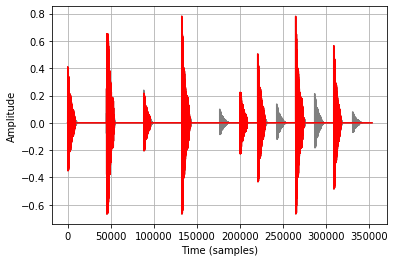

In [9]:
atk = 0.2
rel = 0.03

sig.get_audio_events(sig.data, envPEAK, atk, rel)

R_mono = pyAudGrav.AudioReconstruct(len(sig.data), sig.audio_events)
r_mono = R_mono.reconstruct_mono()

plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.plot(sig.data, 'grey') # original data
plt.plot(r_mono, 'red') # reconstructed signal
plt.grid()
plt.show()

Note: In this example I have purposefully set attack and release thresholds that imperfectely capture the signal. Observe how the beginnings and endings of some of these events are grey. Grey indicates audio information that will not be present in the reconstructed signal. This may cause unattural or choppy sounding audio clips in the final product. As a rule of thumb, attack should be higher than release, and the threshold should be adjusted to capture what would be considered the smallest audio event in your original audio signal that you wish to capture. 

## Write Audio

After that we can use `r_stereo` or `r_mono` as our newly constructed audio signal. 

In [10]:
io.writeWav('jupyter_example_file.wav', r_stereo)

Writing jupyter_example_file.wav | Sample Rate : 44100 | Channels : stereo


In [11]:
ipd.Audio('jupyter_example_file.wav')